This tutorial demonstrates how to generate a Relion Dataset using `cryojax`. This tutorial builds upon tools already shown in other tutorials, so we might skip over some details.

In [1]:
%load_ext autoreload
%autoreload 2

First we will do all the imports required to run the tutorial

In [2]:
# Jax and Equinox imports
from functools import partial

import equinox as eqx
import equinox.internal as eqxi
import jax
import jax.numpy as jnp
from jaxtyping import PRNGKeyArray

In [3]:
# Plotting imports and functions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [4]:
# CryoJAX imports

import cryojax.simulator as cxs
from cryojax.data import (
    RelionDataset,
    RelionParticleStack,
    write_simulated_image_stack_from_starfile,
    write_starfile_with_particle_parameters,
)
from cryojax.image import operators as op
from cryojax.io import read_atoms_from_pdb
from cryojax.rotations import SO3

# Generating a starfile

We have split this tutorial in two parts. In the first part we will generate a starfile, but we will not generate any particles. In the second part we will show how to generate particles from a starfile, and how to save such particles to the respective MRC Files.

We have decided to keep this two steps separate for a simple reason, flexibility. We want to make it possible for every user to design their own image formation pipeline. In some of our other tutorials we have showed how to generate noiseless image, images with solvent noise, or images with noise coming from a distribution. You can easily adapt this tutorial to those cases, or any other pipeline you build.

Now we will start by generating a starfile. To do this, we will first create a cryojax RelionParticleStack.

In this function we vmap over `jax` random keys. You can adapt this function to your needs, such as adapting the range of the distributions for the random parameters, or changing wheter a parameter is random or not.

In [5]:
@partial(eqx.filter_vmap, in_axes=(0, None), out_axes=eqxi.if_mapped(axis=0))
def make_particle_stack(
    key: PRNGKeyArray, instrument_config: cxs.InstrumentConfig
) -> RelionParticleStack:
    # Generate random parameters

    # Pose
    # ... instantiate rotations
    rotation = SO3.sample_uniform(key)
    key, subkey = jax.random.split(key)  # split the key to use for the next random number

    # ... now in-plane translation
    ny, nx = instrument_config.shape
    in_plane_offset_in_angstroms = (
        jax.random.uniform(subkey, (2,), minval=-0.2, maxval=0.2)
        * jnp.asarray((nx, ny))
        * instrument_config.pixel_size
    )
    key, subkey = jax.random.split(key)  # do this everytime you use a key!!

    # ... convert 2D in-plane translation to 3D, setting the out-of-plane translation to
    # zero
    offset_in_angstroms = jnp.pad(in_plane_offset_in_angstroms, ((0, 1),))
    # ... build the pose
    pose = cxs.EulerAnglePose.from_rotation_and_translation(rotation, offset_in_angstroms)

    # CTF Parameters
    # ... defocus
    defocus_in_angstroms = jax.random.uniform(subkey, (), minval=1000, maxval=1500)
    key, subkey = jax.random.split(key)

    astigmatism_in_angstroms = jax.random.uniform(subkey, (), minval=0, maxval=100)
    key, subkey = jax.random.split(key)

    astigmatism_angle = jax.random.uniform(subkey, (), minval=0, maxval=jnp.pi)
    key, subkey = jax.random.split(key)

    phase_shift = jax.random.uniform(subkey, (), minval=0, maxval=0)

    # now generate your non-random values
    spherical_aberration_in_mm = 2.7
    amplitude_contrast_ratio = 0.1
    b_factor = 170.0
    ctf_scale_factor = 1.0

    # ... build the CTF
    transfer_theory = cxs.ContrastTransferTheory(
        ctf=cxs.ContrastTransferFunction(
            defocus_in_angstroms=defocus_in_angstroms,
            astigmatism_in_angstroms=astigmatism_in_angstroms,
            astigmatism_angle=astigmatism_angle,
            voltage_in_kilovolts=instrument_config.voltage_in_kilovolts,
            spherical_aberration_in_mm=spherical_aberration_in_mm,
            amplitude_contrast_ratio=amplitude_contrast_ratio,
            phase_shift=phase_shift,
        ),
        envelope=op.FourierGaussian(b_factor=b_factor, amplitude=ctf_scale_factor),
    )

    relion_particle_stack = RelionParticleStack(
        instrument_config=instrument_config,
        pose=pose,
        transfer_theory=transfer_theory,
    )
    return relion_particle_stack

!!! info "What's with the `out_axes=eqxi.if_mapped(axis=0)`?"
    
    When we create a pytree with `eqx.filter_vmap` (or `jax.vmap`), `out_axes` should have the same structure as the output pytree. If `out_axes` is set to `None` at a particular leaf, this
    says that we do not want to broadcast that leaf (of course, this only works for unmapped leaves). By default `jax.vmap` sets `out_axes=0`, so all unmapped leaves get broadcasted. `equinox` allows us to pass `out_axes=eqxi.if_mapped(axes=0)`, which specifies *not* to broadcast pytree leaves unless the leaves are directly mapped.

In [6]:
# Generate instrument config
instrument_config = cxs.InstrumentConfig(
    shape=(128, 128),
    pixel_size=1.5,
    voltage_in_kilovolts=300.0,
    pad_scale=1.0,  # no padding
)

# Generate RNG keys
number_of_images = 100
keys = jax.random.split(jax.random.PRNGKey(0), number_of_images)

# ... instantiate the RelionParticleStack
particle_stack = make_particle_stack(keys, instrument_config)

In [7]:
particle_stack

RelionParticleStack(
  instrument_config=InstrumentConfig(
    shape=(128, 128),
    pixel_size=f32[],
    voltage_in_kilovolts=f32[],
    electrons_per_angstrom_squared=f32[],
    padded_shape=(128, 128),
    pad_mode='constant'
  ),
  pose=EulerAnglePose(
    offset_x_in_angstroms=f32[100],
    offset_y_in_angstroms=f32[100],
    offset_z_in_angstroms=0.0,
    view_phi=f32[100],
    view_theta=f32[100],
    view_psi=f32[100]
  ),
  transfer_theory=ContrastTransferTheory(
    ctf=ContrastTransferFunction(
      defocus_in_angstroms=f32[100],
      astigmatism_in_angstroms=f32[100],
      astigmatism_angle=f32[100],
      voltage_in_kilovolts=f32[],
      spherical_aberration_in_mm=f32[],
      amplitude_contrast_ratio=f32[],
      phase_shift=f32[100]
    ),
    envelope=FourierGaussian(amplitude=f32[], b_factor=f32[])
  ),
  image_stack=None
)

To see the values of any particular parameter, you can do

Lastly, we can easily generate the starfile from the built-in `cryojax.data.generate_starfile` function.

The `mrc_batch_size` parameter let's you specify how many particles you want per mrcfile.

In this case we will place 50 images per mrcfile, giving us two mrcfiles.

In [24]:
# ... generate the starfile
write_starfile_with_particle_parameters(
    particle_stack, "relion_dataset.star", mrc_batch_size=50
)

# Simulating particles based on a starfile and writing them to mrcs

Now we will see how to define the functions required for our `write_simulated_image_stack_from_starfile` function to work.

First, let's define our potential and let's load the starfile

## Simulating noiseless images

First, we will generate a stack without noise using one of `cryojax` imaging pipelines.

In [9]:
# First load the starfile

path_to_mrc_files = "./relion_dataset_particles/noiseless"

dataset = RelionDataset(
    path_to_starfile="./relion_dataset.star",  # starfile we created
    path_to_relion_project=path_to_mrc_files,  # here is where the mrcs will be saved
    get_image_stack=False,  # not loading particles as they don't exist yet
    get_envelope_function=True,
)

!!! info "For more information on the RelionDataset object, check our `Read a particle stack` tutorial."

Now let's define the structure we will use to generate images. In this case, we show how to load a pdb and then turn it into a voxel grid. We all need to define how we will integrate our potential.

In [10]:
filename = "./data/groel_chainA.pdb"
atom_positions, atom_identities, b_factors = read_atoms_from_pdb(
    filename, assemble=False, get_b_factors=True
)
atomic_potential = cxs.PengAtomicPotential(atom_positions, atom_identities, b_factors)

# get values from the "optics" datablock in the starfile
box_size = dataset[0].instrument_config.shape[0]
voxel_size = dataset[0].instrument_config.pixel_size

real_voxel_grid = atomic_potential.as_real_voxel_grid(
    shape=(box_size, box_size, box_size), voxel_size=voxel_size
)
potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
    real_voxel_grid, voxel_size, pad_scale=2
)

potential_integrator = cxs.FourierSliceExtraction(interpolation_order=1)

Now we will build a function that generates an imaging pipeline from a relion_particle_stack

In [11]:
from typing import Any


def build_imaging_pipeline_from_relion_particle_stack(
    relion_particle_stack: RelionParticleStack,
    args: Any,
) -> cxs.ContrastImagingPipeline:
    potential, potential_integrator = args

    structural_ensemble = cxs.SingleStructureEnsemble(
        potential, relion_particle_stack.pose
    )

    scattering_theory = cxs.WeakPhaseScatteringTheory(
        structural_ensemble,
        potential_integrator,
        relion_particle_stack.transfer_theory,
    )
    imaging_pipeline = cxs.ContrastImagingPipeline(
        relion_particle_stack.instrument_config, scattering_theory
    )
    return imaging_pipeline

and a function that simply computes images from a relion_particle_stack. They don't really need to be in separate functions.

In [12]:
def compute_image(
    relion_particle_stack: RelionParticleStack,
    args: Any,
):
    imaging_pipeline = build_imaging_pipeline_from_relion_particle_stack(
        relion_particle_stack, args
    )
    return imaging_pipeline.render()

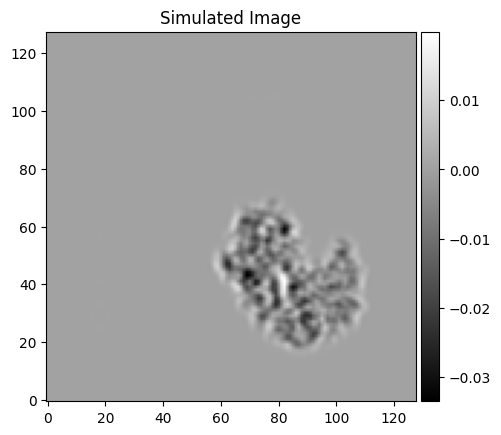

In [13]:
image = compute_image(dataset[0], (potential, potential_integrator))
plot_image(image, plt.figure(), plt.gca(), label="Simulated Image");

Finally, we can use this function to write a particle stack!

In [14]:
args = (potential, potential_integrator)  # the args compute_image takes

write_simulated_image_stack_from_starfile(dataset, compute_image, args, overwrite=True)

!!! info "How does `write_simulated_image_stack_from_starfile` work?"

    The main arguments to call this function are:
    * `dataset`: needs to be an instance of `RelionDataset`
    * `compute_image`: function that should take (RelionDataset, args) or (jax.PRNGKey, RelionDataset, args) as input
    * `args`: the args for compute_image
    * `seed`: a see for generating noise (Optional)

    If you add a seed, then `compute_image` should take a `jax.PRNGKey` as its first argument (next example), which is needed to generate a sample of the noise from whatever distribution you define.

    Inside our code we will call your `compute_image` function to generate an image stack, and then save it as an mrcfile.

!!! info "For more information on imaging pipelines check the `Simulate an image` tutorial."

## Simulating images with a noise distribution

In this example we will use a cryojax distribution to add the noise, but in practice you can do it however you want.

We need a different dataset, as we will save these images in a different folder

In [15]:
# First load the starfile

path_to_mrc_files = "./relion_dataset_particles/with_noise"

dataset_noise = RelionDataset(
    path_to_starfile="./relion_dataset.star",  # starfile we created
    path_to_relion_project=path_to_mrc_files,  # here is where the mrcs will be saved
    get_image_stack=False,  # not loading particles as they don't exist yet
    get_envelope_function=True,
)

the other parameters do not change, so there is no need to initialize them again.

We will follow a simular approach as before. First, let's write a function that generates a distribution from a `RelionParticleStack`:

In [16]:
from cryojax.inference import distributions as dist


def build_distribution_from_relion_particle_stack(
    relion_particle_stack: RelionParticleStack,
    args: Any,
) -> cxs.ContrastImagingPipeline:
    potential, potential_integrator = args

    structural_ensemble = cxs.SingleStructureEnsemble(
        potential, relion_particle_stack.pose
    )

    scattering_theory = cxs.WeakPhaseScatteringTheory(
        structural_ensemble,
        potential_integrator,
        relion_particle_stack.transfer_theory,
    )
    imaging_pipeline = cxs.ContrastImagingPipeline(
        relion_particle_stack.instrument_config, scattering_theory
    )
    distribution = dist.IndependentGaussianFourierModes(
        imaging_pipeline,
        signal_scale_factor=jnp.sqrt(instrument_config.n_pixels),
        variance_function=op.Constant(1.0),
    )
    return distribution

and a function that generates an image

In [17]:
def compute_image_with_noise(
    key: PRNGKeyArray,
    relion_particle_stack: RelionParticleStack,
    args: Any,
):
    distribution = build_distribution_from_relion_particle_stack(
        relion_particle_stack, args
    )
    return distribution.sample(key)

and generate an image from such distribution

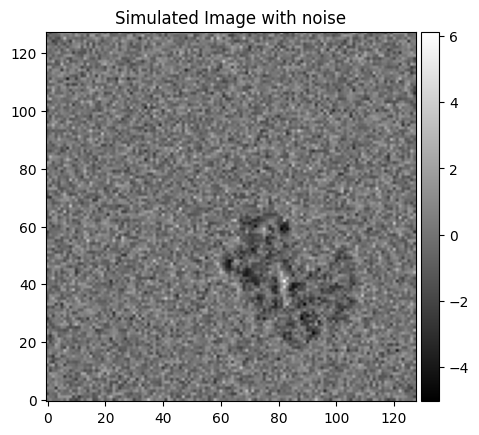

In [18]:
key = jax.random.PRNGKey(0)

image_with_noise = compute_image_with_noise(
    key, dataset_noise[0], (potential, potential_integrator)
)
plot_image(image_with_noise, plt.figure(), plt.gca(), label="Simulated Image with noise");

In [19]:
key, *subkeys = jax.random.split(key, 3)

subkeys = jnp.array(subkeys)

subkeys.shape

(2, 2)

Lastly, let's generate a stack with noise

In [20]:
args = (potential, potential_integrator)  # the args compute_image takes

write_simulated_image_stack_from_starfile(
    dataset_noise, compute_image_with_noise, args, seed=0, overwrite=True
)

Now we can load our Datasets with `get_image_stack=True` as the particles do exist now

In [21]:
dataset_noiseless = RelionDataset(
    path_to_starfile="relion_dataset.star",
    path_to_relion_project="relion_dataset_particles/noiseless",
    get_image_stack=True,
    get_envelope_function=True,
)

dataset_noisy = RelionDataset(
    path_to_starfile="relion_dataset.star",
    path_to_relion_project="relion_dataset_particles/with_noise",
    get_image_stack=True,
    get_envelope_function=True,
)

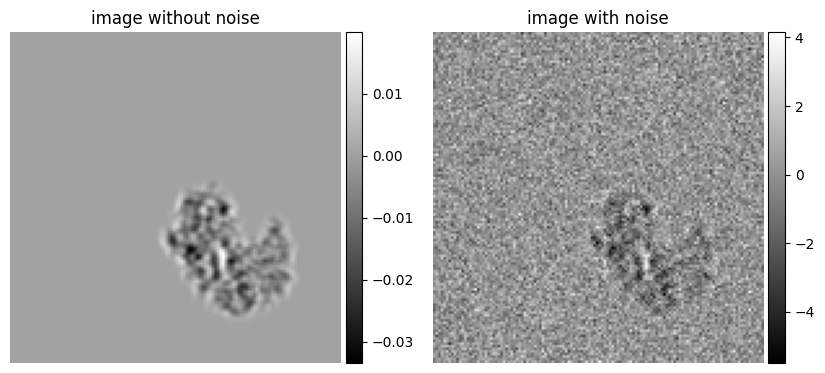

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for a in ax:
    a.set_axis_off()

im1 = plot_image(
    dataset_noiseless[0].image_stack,
    fig,
    ax[0],
    label="image without noise",
)

im2 = plot_image(
    dataset_noisy[0].image_stack,
    fig,
    ax[1],
    label="image with noise",
)